In [ ]:
#This is a notebook adaption of the DevNet algorithm of Pang et al
# -*- coding: utf-8 -*-
"""
@author: Guansong Pang
The algorithm was implemented using Python 3.6.6, Keras 2.2.2 and TensorFlow 1.10.1.
More details can be found in our KDD19 paper.
Guansong Pang, Chunhua Shen, and Anton van den Hengel. 2019. 
Deep Anomaly Detection with Deviation Networks. 
In The 25th ACM SIGKDDConference on Knowledge Discovery and Data Mining (KDD ’19),
August4–8, 2019, Anchorage, AK, USA.ACM, New York, NY, USA, 10 pages. https://doi.org/10.1145/3292500.3330871
"""
#it has been modified minimally to work with colab using the goole tensorflow1.x platform 
#as of December 2021 this required the notebook run with an earlier version of h5py

'\n@author: Guansong Pang\nThe algorithm was implemented using Python 3.6.6, Keras 2.2.2 and TensorFlow 1.10.1.\nMore details can be found in our KDD19 paper.\nGuansong Pang, Chunhua Shen, and Anton van den Hengel. 2019. \nDeep Anomaly Detection with Deviation Networks. \nIn The 25th ACM SIGKDDConference on Knowledge Discovery and Data Mining (KDD ’19),\nAugust4–8, 2019, Anchorage, AK, USA.ACM, New York, NY, USA, 10 pages. https://doi.org/10.1145/3292500.3330871\n'

In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# make one local directories named model
import os
os.mkdir('./model')


In [8]:
%tensorflow_version 1.x
#!pip uninstall h5py
!pip install 'h5py<3.0.0'

TensorFlow 1.x selected.
     |████████████████████████████████| 2.9 MB 5.4 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [9]:

import pandas as pd
import numpy as np
from sklearn.metrics import auc,roc_curve, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn import preprocessing
import matplotlib.pyplot as plt

from sklearn.datasets import load_svmlight_file


def dataLoading(path):
    # loading data
    df = pd.read_csv(path) 
    
    labels = df['class']
    
    x_df = df.drop(['class'], axis=1)
    
    x = x_df.values
    print("Data shape: (%d, %d)" % x.shape)
    
    return x, labels;


def aucPerformance(mse, labels):
    roc_auc = roc_auc_score(labels, mse)
    ap = average_precision_score(labels, mse)
    print("AUC-ROC: %.4f, AUC-PR: %.4f" % (roc_auc, ap))
    return roc_auc, ap;

def writeResults(name, n_samples, dim, n_samples_trn, n_outliers_trn, n_outliers, depth, rauc, ap, std_auc, std_ap, train_time, test_time, path = "./results/auc_performance_cl0.5.csv"):    
    csv_file = open(path, 'a') 
    row = name + "," + str(n_samples)+ ","  + str(dim) + ',' + str(n_samples_trn) + ','+ str(n_outliers_trn) + ','+ str(n_outliers)  + ',' + str(depth)+ "," + str(rauc) +"," + str(std_auc) + "," + str(ap) +"," + str(std_ap)+"," + str(train_time)+"," + str(test_time) + "\n"
    csv_file.write(row)




In [10]:
import numpy as np

import tensorflow as tf
from keras import regularizers
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard

import argparse
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.sparse import vstack, csc_matrix
#from utils import dataLoading, aucPerformance, writeResults   #notebook version
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, plot_precision_recall_curve

from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

import time

Using TensorFlow backend.


In [11]:
def dev_network_d(input_shape):
    '''
    deeper network architecture with three hidden layers
    '''
    x_input = Input(shape=input_shape)
    intermediate = Dense(1000, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl1')(x_input)
    intermediate = Dense(250, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl2')(intermediate)
    intermediate = Dense(20, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl3')(intermediate)
    intermediate = Dense(1, activation='linear', name = 'score')(intermediate)
    return Model(x_input, intermediate)

def dev_network_s(input_shape):
    '''
    network architecture with one hidden layer
    '''
    x_input = Input(shape=input_shape)
    intermediate = Dense(20, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01), name = 'hl1')(x_input)
    intermediate = Dense(1, activation='linear',  name = 'score')(intermediate)    
    return Model(x_input, intermediate)

def dev_network_linear(input_shape):
    '''
    network architecture with no hidden layer, equivalent to linear mapping from
    raw inputs to anomaly scores
    '''    
    x_input = Input(shape=input_shape)
    intermediate = Dense(1, activation='linear',  name = 'score')(x_input)
    return Model(x_input, intermediate)

def deviation_loss(y_true, y_pred):
    '''
    z-score-based deviation loss
    '''    
    confidence_margin = 5.     
    ## size=5000 is the setting of l in algorithm 1 in the paper
    ref = K.variable(np.random.normal(loc = 0., scale= 1.0, size = 5000) , dtype='float32')
    dev = (y_pred - K.mean(ref)) / K.std(ref)
    inlier_loss = K.abs(dev) 
    outlier_loss = K.abs(K.maximum(confidence_margin - dev, 0.))
    return K.mean((1 - y_true) * inlier_loss + y_true * outlier_loss)


def deviation_network(input_shape, network_depth):
    '''
    construct the deviation network-based detection model
    '''
    if network_depth == 4:
        model = dev_network_d(input_shape)
    elif network_depth == 2:
        model = dev_network_s(input_shape)
    elif network_depth == 1:
        model = dev_network_linear(input_shape)
    else:
        sys.exit("The network depth is not set properly")
    rms = RMSprop(clipnorm=1.)
    model.compile(loss=deviation_loss, optimizer=rms)
    return model


def batch_generator_sup(x, outlier_indices, inlier_indices, batch_size, nb_batch, rng):
    """batch generator
    """
    rng = np.random.RandomState(rng.randint(MAX_INT, size = 1))
    counter = 0
    while 1:                
        if data_format == 0:
            ref, training_labels = input_batch_generation_sup(x, outlier_indices, inlier_indices, batch_size, rng)
        else:
            ref, training_labels = input_batch_generation_sup_sparse(x, outlier_indices, inlier_indices, batch_size, rng)
        counter += 1
        yield(ref, training_labels)
        if (counter > nb_batch):
            counter = 0
 
def input_batch_generation_sup(x_train, outlier_indices, inlier_indices, batch_size, rng):
    '''
    batchs of samples. This is for csv data.
    Alternates between positive and negative pairs.
    '''      
    dim = x_train.shape[1]
    ref = np.empty((batch_size, dim))    
    training_labels = []
    n_inliers = len(inlier_indices)
    n_outliers = len(outlier_indices)
    for i in range(batch_size):    
        if(i % 2 == 0):
            sid = rng.choice(n_inliers, 1)
            ref[i] = x_train[inlier_indices[sid]]
            training_labels += [0]
        else:
            sid = rng.choice(n_outliers, 1)
            ref[i] = x_train[outlier_indices[sid]]
            training_labels += [1]
    return np.array(ref), np.array(training_labels)

 
def input_batch_generation_sup_sparse(x_train, outlier_indices, inlier_indices, batch_size, rng):
    '''
    batchs of samples. This is for libsvm stored sparse data.
    Alternates between positive and negative pairs.
    '''      
    ref = np.empty((batch_size))    
    training_labels = []
    n_inliers = len(inlier_indices)
    n_outliers = len(outlier_indices)
    for i in range(batch_size):    
        if(i % 2 == 0):
            sid = rng.choice(n_inliers, 1)
            ref[i] = inlier_indices[sid]
            training_labels += [0]
        else:
            sid = rng.choice(n_outliers, 1)
            ref[i] = outlier_indices[sid]
            training_labels += [1]
    ref = x_train[ref, :].toarray()
    return ref, np.array(training_labels)


def load_model_weight_predict(model_name, input_shape, network_depth, x_test):
    '''
    load the saved weights to make predictions
    '''
    model = deviation_network(input_shape, network_depth)
    model.load_weights(model_name)
    scoring_network = Model(inputs=model.input, outputs=model.output)    
    
    if data_format == 0:
        scores = scoring_network.predict(x_test)
    else:
        data_size = x_test.shape[0]
        scores = np.zeros([data_size, 1])
        count = 512
        i = 0
        while i < data_size:
            subset = x_test[i:count].toarray()
            scores[i:count] = scoring_network.predict(subset)
            if i % 1024 == 0:
                print(i)
            i = count
            count += 512
            if count > data_size:
                count = data_size
        assert count == data_size
    return scores


def inject_noise_sparse(seed, n_out, random_seed):  
    '''
    add anomalies to training data to replicate anomaly contaminated data sets.
    we randomly swape 5% features of anomalies to avoid duplicate contaminated anomalies.
    This is for sparse data.
    '''
    rng = np.random.RandomState(random_seed) 
    n_sample, dim = seed.shape
    swap_ratio = 0.05
    n_swap_feat = int(swap_ratio * dim)
    seed = seed.tocsc()
    noise = csc_matrix((n_out, dim))
    print(noise.shape)
    for i in np.arange(n_out):
        outlier_idx = rng.choice(n_sample, 2, replace = False)
        o1 = seed[outlier_idx[0]]
        o2 = seed[outlier_idx[1]]
        swap_feats = rng.choice(dim, n_swap_feat, replace = False)
        noise[i] = o1.copy()
        noise[i, swap_feats] = o2[0, swap_feats]
    return noise.tocsr()

def inject_noise(seed, n_out, random_seed):   
    '''
    add anomalies to training data to replicate anomaly contaminated data sets.
    we randomly swape 5% features of anomalies to avoid duplicate contaminated anomalies.
    this is for dense data
    '''  
    rng = np.random.RandomState(random_seed) 
    n_sample, dim = seed.shape
    swap_ratio = 0.05
    n_swap_feat = int(swap_ratio * dim)
    noise = np.empty((n_out, dim))
    for i in np.arange(n_out):
        outlier_idx = rng.choice(n_sample, 2, replace = False)
        o1 = seed[outlier_idx[0]]
        o2 = seed[outlier_idx[1]]
        swap_feats = rng.choice(dim, n_swap_feat, replace = False)
        noise[i] = o1.copy()
        noise[i, swap_feats] = o2[swap_feats]
    return noise

def plotAUCPRCurve(y_test, y_score):
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    fig = plt.figure()
    plt.plot(recall, precision)
    fig.suptitle('DevNet AUC-PR ', fontsize=20)
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=16)
    plt.show()

    # Data to plot precision - recall curve
    # PrecisionRecallDisplay.from_predictions(y_test, y_score)
    # RocCurveDisplay.from_predictions( y_test, y_score)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    fig = plt.figure()
    plt.plot(fpr, tpr)
    fig.suptitle('DevNet AUC-ROC ', fontsize=20)
    plt.xlabel('FPR', fontsize=18)
    plt.ylabel('TPR', fontsize=16)
    plt.show()



In [12]:
def run_devnet(data_set, 
               n_depth, 
               ramdn_seed, 
               runs, 
               data_format, 
               input_path,cont_rate, 
               known_outliers,
               epochs,
               batch_size,
               nb_batch,
               output):

    names = data_set.split(',')
    #names = ['annthyroid_21feat_normalised']
    network_depth = int(n_depth)
    random_seed = ramdn_seed
    for nm in names:
        runs = runs
        rauc = np.zeros(runs)
        ap = np.zeros(runs)  
        filename = nm.strip()
        #global data_format   # what does global do?
        data_format = int(data_format)
        if data_format == 0:
            x, labels = dataLoading(input_path + filename + ".csv")
        else:
            pass
            #x, labels = get_data_from_svmlight_file(input_path + filename + ".svm")
            #x = x.tocsr()
        outlier_indices = np.where(labels == 1)[0]
        outliers = x[outlier_indices]  
        n_outliers_org = outliers.shape[0]   
        
        train_time = 0
        test_time = 0
        for i in np.arange(runs):  
            x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=0.2, random_state=42, stratify = labels)
            y_train = np.array(y_train)
            y_test = np.array(y_test)
            print(filename + ': round ' + str(i))
            outlier_indices = np.where(y_train == 1)[0]
            inlier_indices = np.where(y_train == 0)[0]
            n_outliers = len(outlier_indices)
            print("Original training size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))
            
            n_noise  = len(np.where(y_train == 0)[0]) * cont_rate / (1. - cont_rate)
            n_noise = int(n_noise)                
            
            rng = np.random.RandomState(random_seed)  
            if data_format == 0:                
                if n_outliers > known_outliers:
                    mn = n_outliers - known_outliers
                    remove_idx = rng.choice(outlier_indices, mn, replace=False)            
                    x_train = np.delete(x_train, remove_idx, axis=0)
                    y_train = np.delete(y_train, remove_idx, axis=0)
                
                noises = inject_noise(outliers, n_noise, random_seed)
                x_train = np.append(x_train, noises, axis = 0)
                y_train = np.append(y_train, np.zeros((noises.shape[0], 1)))
            
            else:
                if n_outliers > known_outliers:
                    mn = n_outliers - known_outliers
                    remove_idx = rng.choice(outlier_indices, mn, replace=False)        
                    retain_idx = set(np.arange(x_train.shape[0])) - set(remove_idx)
                    retain_idx = list(retain_idx)
                    x_train = x_train[retain_idx]
                    y_train = y_train[retain_idx]                               
                
                noises = inject_noise_sparse(outliers, n_noise, random_seed)
                x_train = vstack([x_train, noises])
                y_train = np.append(y_train, np.zeros((noises.shape[0], 1)))
            
            outlier_indices = np.where(y_train == 1)[0]
            inlier_indices = np.where(y_train == 0)[0]
            print(y_train.shape[0], outlier_indices.shape[0], inlier_indices.shape[0], n_noise)
            input_shape = x_train.shape[1:]
            n_samples_trn = x_train.shape[0]
            n_outliers = len(outlier_indices)            
            print("Training data size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))
            
            
            start_time = time.time() 
            input_shape = x_train.shape[1:]
            epochs = epochs
            batch_size = batch_size    
            nb_batch = nb_batch  
            model = deviation_network(input_shape, network_depth)
            print(model.summary())  
            model_name = "./model/devnet_"  + filename + "_" + str(cont_rate) + "cr_"  + str(batch_size) +"bs_" + str(known_outliers) + "ko_" + str(network_depth) +"d.h5"
            checkpointer = ModelCheckpoint(model_name, monitor='loss', verbose=0,
                                           save_best_only = True, save_weights_only = True)            
            
            model.fit_generator(batch_generator_sup(x_train, outlier_indices, inlier_indices, batch_size, nb_batch, rng),
                                          steps_per_epoch = nb_batch,
                                          epochs = epochs,
                                          callbacks=[checkpointer])   
            train_time += time.time() - start_time
            
            start_time = time.time() 
            scores = load_model_weight_predict(model_name, input_shape, network_depth, x_test)
            test_time += time.time() - start_time
            rauc[i], ap[i] = aucPerformance(scores, y_test)
            plotAUCPRCurve(y_test, scores)
        mean_auc = np.mean(rauc)
        std_auc = np.std(rauc)
        mean_aucpr = np.mean(ap)
        std_aucpr = np.std(ap)
        train_time = train_time/runs
        test_time = test_time/runs
        print("average AUC-ROC: %.4f, average AUC-PR: %.4f" % (mean_auc, mean_aucpr))    
        print("average runtime: %.4f seconds" % (train_time + test_time))
        writeResults(filename+'_'+str(network_depth), x.shape[0], x.shape[1], n_samples_trn, n_outliers_org, n_outliers,
        network_depth, mean_auc, mean_aucpr, std_auc, std_aucpr, train_time, test_time, path=output)



Data shape: (284807, 29)
creditcardfraud_normalised_mn_scaled_1.0: round 0
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 0s 21ms/step - loss: 2.6067
Epoch 2/50
20/20 [==============================] - 0s 16ms/step - loss: 2.3526
Epoch 3/50
20/20 [==================

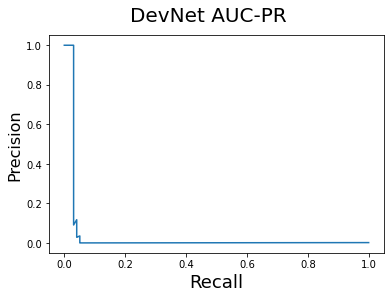

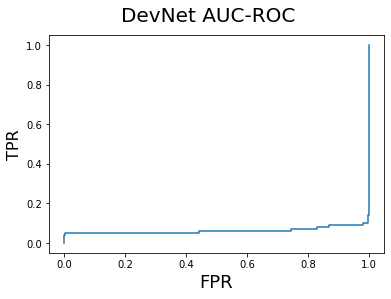

creditcardfraud_normalised_mn_scaled_1.0: round 1
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 0s 23ms/step - loss: 2.5955
Epoch 2/50
20/20 [==============================] - 0s 15ms/step - loss: 2.3703
Epoch 3/50
20/20 [==============================] - 0s 18ms/s

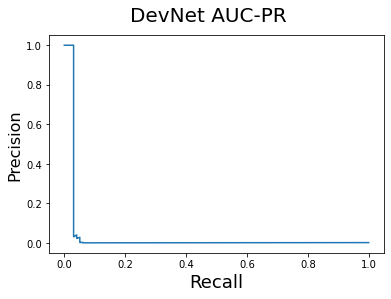

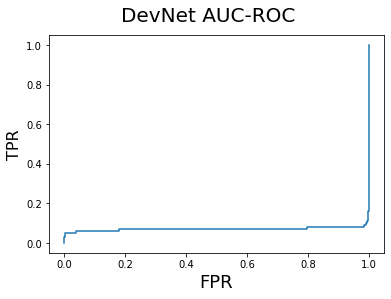

creditcardfraud_normalised_mn_scaled_1.0: round 2
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 0s 23ms/step - loss: 2.5559
Epoch 2/50
20/20 [==============================] - 0s 13ms/step - loss: 2.4407
Epoch 3/50
20/20 [==============================] - 0s 19ms/s

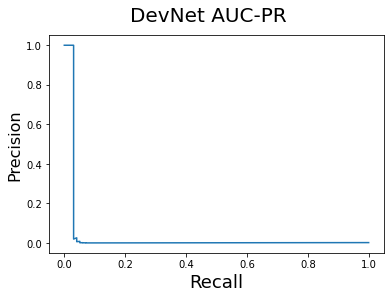

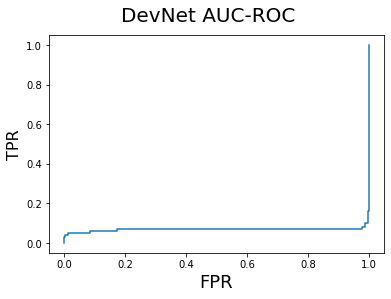

creditcardfraud_normalised_mn_scaled_1.0: round 3
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 0s 23ms/step - loss: 2.4001
Epoch 2/50
20/20 [==============================] - 0s 14ms/step - loss: 2.1822
Epoch 3/50
20/20 [==============================] - 0s 20ms/

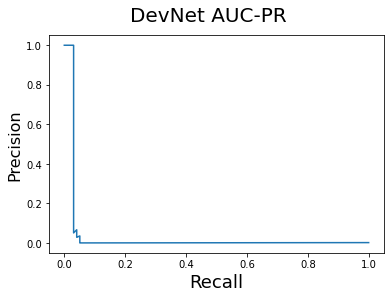

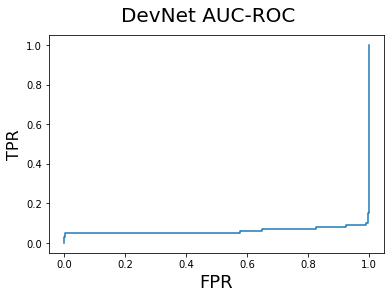

creditcardfraud_normalised_mn_scaled_1.0: round 4
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 0s 24ms/step - loss: 2.6939
Epoch 2/50
20/20 [==============================] - 0s 12ms/step - loss: 2.3924
Epoch 3/50
20/20 [==============================] - 0s 20ms/

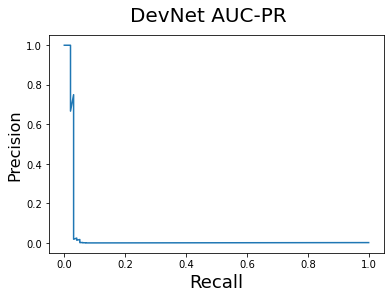

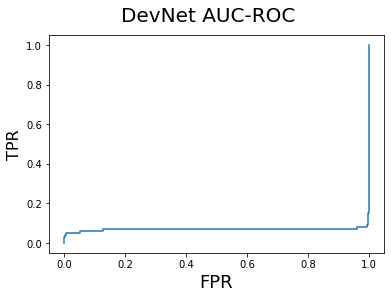

creditcardfraud_normalised_mn_scaled_1.0: round 5
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 1s 27ms/step - loss: 2.8170
Epoch 2/50
20/20 [==============================] - 0s 10ms/step - loss: 2.6945
Epoch 3/50
20/20 [==============================] - 0s 20ms/

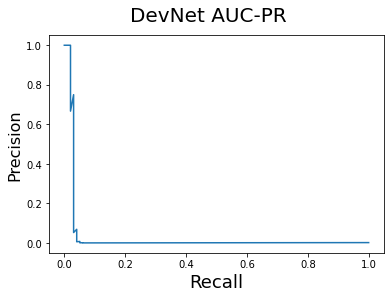

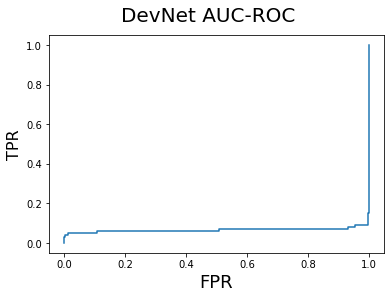

creditcardfraud_normalised_mn_scaled_1.0: round 6
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 1s 27ms/step - loss: 2.7062
Epoch 2/50
20/20 [==============================] - 0s 11ms/step - loss: 2.4416
Epoch 3/50
20/20 [==============================] - 0s 19ms/

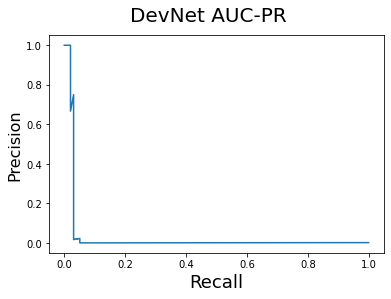

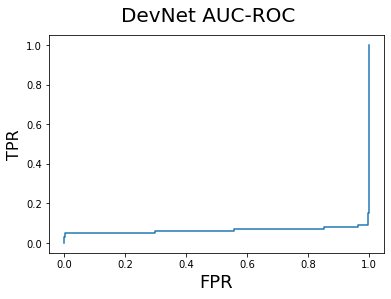

creditcardfraud_normalised_mn_scaled_1.0: round 7
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 1s 30ms/step - loss: 2.4103
Epoch 2/50
20/20 [==============================] - 0s 11ms/step - loss: 2.1724
Epoch 3/50
20/20 [==============================] - 0s 19ms/

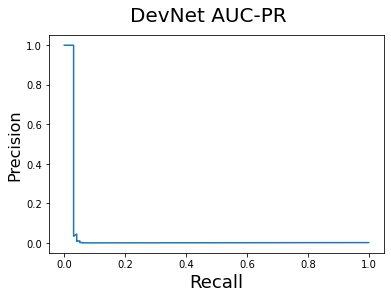

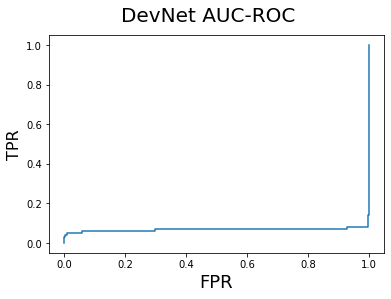

creditcardfraud_normalised_mn_scaled_1.0: round 8
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 1s 30ms/step - loss: 2.7390
Epoch 2/50
20/20 [==============================] - 0s 11ms/step - loss: 2.5167
Epoch 3/50
20/20 [==============================] - 0s 19ms/

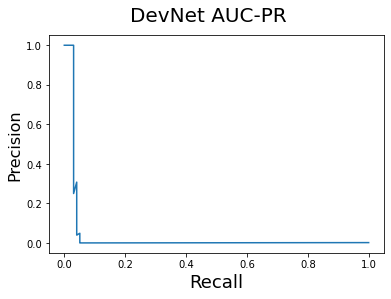

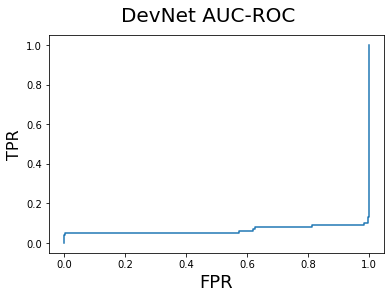

creditcardfraud_normalised_mn_scaled_1.0: round 9
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 1s 33ms/step - loss: 2.4610
Epoch 2/50
20/20 [==============================] - 0s 11ms/step - loss: 2.2905
Epoch 3/50
20/20 [==============================] - 0s 19ms/

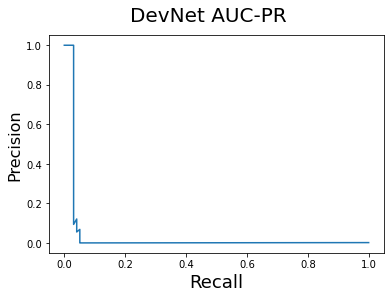

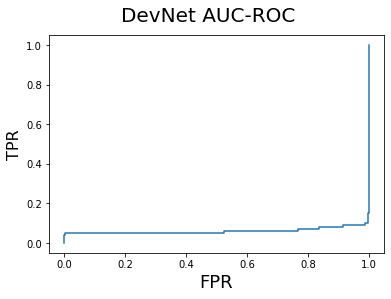

average AUC-ROC: 0.0662, average AUC-PR: 0.0319
average runtime: 23.0617 seconds


In [14]:
#This is the driver cell
#for each run change the name of the dataset file
#if running semi-supervised intentionally set the number of known outliers (generally 1% may work)
#if running unsupervised then set known_outliers =1
network_depth=2 # choices=['1','2', '4'], default='2', help="the depth of the network architecture")
batch_size=512 # type=int, default=512, help="batch size used in SGD")
nb_batch=20 # type=int, default=20, help="the number of batches per epoch")
epochs=50 #type=int, default=50, help="the number of epochs")
runs=10   #type=int, default=10, help="how many times we repeat the experiments to obtain the average performance")
 # type=int, default=30, help="the number of labeled outliers available at hand")
cont_rate=0.02 # type=float, default=0.02, help="the outlier contamination rate in the training data")
input_path='gdrive/MyDrive/CSCI5523GroupAnomalyProject/data/'   #type=str, default='./dataset/', help="the path of the data sets")
data_set='annthyroid_21feat_normalised' #type=str, default='annthyroid_21feat_normalised', help="a list of data set names")
data_format=0  # choices=['0','1'], default='0',  help="specify whether the input data is a csv (0) or libsvm (1) data format")
output='gdrive/MyDrive/CSCI5523GroupAnomalyProject/data/results.csv' # type=str, default='./results/devnet_auc_performance_30outliers_0.02contrate_2depth_10runs.csv', help="the output file path")
ramdn_seed=42   # type=int, default=42, help="the random seed number")
network_depth=2 


np.random.seed(24)
tf.set_random_seed(24)
sess = tf.Session()
MAX_INT = np.iinfo(np.int32).max

known_outliers=1
mn_scales=[0.1, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]
#cov_scales=[.5, 1, 1.1, 1.5]
cov_scales=[1]
mn_scales=[1.0]
#input_path=input_path+'CreditCardSyntheticCauchy/'
#input_path=input_path+'CreditCardSyntheticStudentT/'
input_path=input_path+'CreditCardSyntheticGaussian/'
#for mn_scale in mn_scales:
for scale in mn_scales:
    for cov_scale in cov_scales:
        #outfilename= 'cc_synthetic_cauchy_mn_scale_'+str(mn_scale)+'_cov_scale_'+str(cov_scale)
        #outfilename= 'cc_synthetic_heavytail_mn_scale_'+str(mn_scale)+'_cov_scale_'+str(cov_scale)
        outfilename=  'creditcardfraud_normalised_mn_scaled_'+str(scale)
        data_set=outfilename

        run_devnet(data_set, 
               network_depth, 
               ramdn_seed, 
               runs, 
               data_format, 
               input_path,cont_rate, 
               known_outliers,
               epochs,
               batch_size,
               nb_batch,
               output)
